In [1]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from einops import rearrange
from gluonts.dataset.pandas import PandasDataset, is_uniform, infer_freq
from gluonts.dataset.split import split, TestData
from uni2ts.model.moirai import MoiraiForecast, MoiraiModule
from uni2ts.eval_util.plot import plot_single, plot_next_multi
from uni2ts.eval_util.evaluation import evaluate_model
from gluonts.ev.metrics import MAE, MAPE

from mov_av import moving_average

In [2]:
it_data_23_24 = pd.read_csv('data/it_load_data_23_24.csv', delimiter=',')
it_data_23_24['DateUTC'] = pd.to_datetime(it_data_23_24['DateUTC'])
it_data_23_24 = it_data_23_24.set_index('DateUTC')

In [3]:
from uni2ts.alex.common.benchmark_func import *

In [9]:
def get_metrics_v2(model_folder: str, data: pd.DataFrame):
    metrics = {"mean": [], "median": [], "lower_0025": [], "upper_0975": []}
    for i in range(1, 52):
        try:
            model, test_data = get_model_data(
                                    model_folder=model_folder,
                                    prediction_lenght=168,
                                    num_of_weeks=i,
                                    data=data,
                                    patch_size="auto",
                                    num_samples=20,
                                )
            
            forecast_samples, target_values = get_eval_foreasts(model, test_data)
    
            # absolute error of the average forecast of each time step
            mean_error_ts = (np.mean(forecast_samples, axis=1).flatten() - target_values.flatten())/target_values.flatten()
            mean_error_ts = np.abs(mean_error_ts)
    
            # absolute error of the median forecast of each time step
            median_error_ts = (np.quantile(forecast_samples, 0.5, axis=1).flatten() - target_values.flatten())/target_values.flatten()
            median_error_ts = np.abs(median_error_ts)
    
            # absolute error of the 97.5th percentile forecast of each time step
            upper_error_ts = (np.quantile(forecast_samples, 0.975, axis=1).flatten() - target_values.flatten())/target_values.flatten()
            upper_error_ts = np.abs(upper_error_ts)
    
            # absolute error of the 2.5th percentile forecast of each time step
            lower_error_ts = (np.quantile(forecast_samples, 0.025, axis=1).flatten() - target_values.flatten())/target_values.flatten()
            lower_error_ts = np.abs(lower_error_ts)
    
            metrics['mean'].append(mean_error_ts)
            metrics['median'].append(median_error_ts)
            metrics['lower_0025'].append(lower_error_ts)
            metrics['upper_0975'].append(upper_error_ts)
        except:
            pass

    return metrics

In [10]:
data = it_data_23_24

model_folder = "outputs/finetune/moirai_small/refit_t_thorough_f/checkpoints/it_load_data_train_"
backtesting_with_refit = get_metrics_v2(model_folder, data)

model_folder = "outputs/finetune/moirai_small/refit_f_thorough_f/checkpoints/it_load_data_train_"
refit_1_pass =  get_metrics_v2(model_folder, data)

model_folder = "outputs/finetune/moirai_small/refit_f_thorough_t/checkpoints/it_load_data_train_"
refit_multiple_passes = get_metrics_v2(model_folder, data)

model_folder = "outputs/finetune/moirai_small/refit_f_thorough_t_dropout_01/checkpoints/it_load_data_train_"
refit_multiple_passes_v2 = get_metrics_v2(model_folder, data)

model_folder = "pretrained"
pretrained = get_metrics_v2(model_folder, data)

In [11]:
# backtesting_with_refit = pd.concat(backtesting_with_refit, axis=0)
# refit_1_pass = pd.concat(refit_1_pass, axis=0)
# refit_multiple_passes = pd.concat(refit_multiple_passes, axis=0)
# pretrained = pd.concat(pretrained, axis=0)

backtesting_with_refit = pd.DataFrame.from_dict(backtesting_with_refit)
refit_1_pass = pd.DataFrame.from_dict(refit_1_pass)
refit_multiple_passes = pd.DataFrame.from_dict(refit_multiple_passes)
refit_multiple_passes_v2 = pd.DataFrame.from_dict(refit_multiple_passes_v2)
pretrained = pd.DataFrame.from_dict(pretrained)

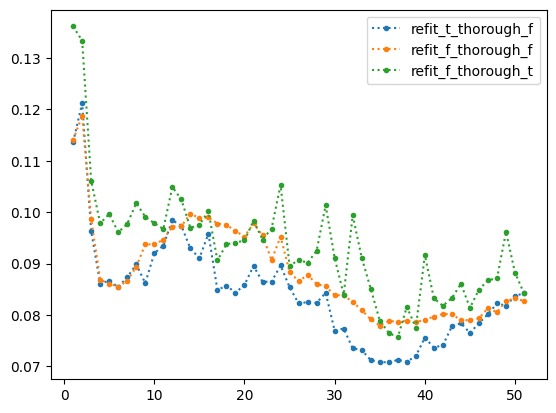

In [37]:
# MAPE of the average forecast
plt.errorbar(x=range(1, 52), y=[np.mean(ts) for ts in backtesting_with_refit['mean'].tolist()], 
             ecolor='red', barsabove=True, linestyle='dotted', marker=".", errorevery=2, label="refit_t_thorough_f")
# MAPE of the median forecast
plt.errorbar(x=range(1, 52), y=[np.mean(ts) for ts in refit_1_pass['mean'].tolist()], 
             ecolor='red', barsabove=True, linestyle='dotted', marker=".", errorevery=2, label="refit_f_thorough_f")
# MAPE of the 97.5th percentile forecast
plt.errorbar(x=range(1, 52), y=[np.mean(ts) for ts in refit_multiple_passes['mean'].tolist()], 
             ecolor='red', barsabove=True, linestyle='dotted', marker=".", errorevery=2, label="refit_f_thorough_t")
# MAPE of the 2.5th percentile forecast
# plt.errorbar(x=range(1, 43), y=[np.mean(ts) for ts in refit_multiple_passes_v2['mean'].tolist()], 
#              ecolor='red', barsabove=True, linestyle='dotted', marker=".", errorevery=2, label="refit_f_thorough_t_dropout_v2")
# plt.errorbar(x=range(1, 52), y=[np.mean(ts) for ts in pretrained['mean'].tolist()], 
#              ecolor='red', barsabove=True, linestyle='dotted', marker=".", errorevery=2, label="pretrained")
plt.legend();

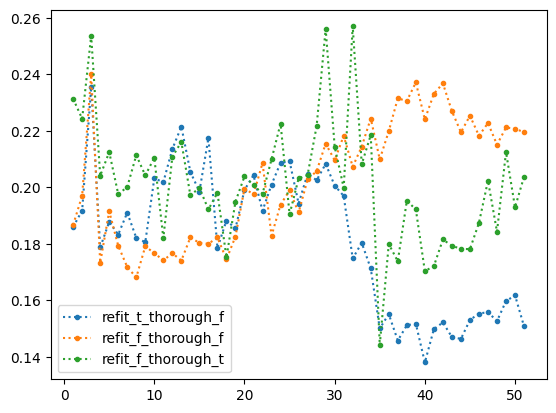

In [38]:
# MAPE of the 97.5th percentile forecast
plt.errorbar(x=range(1, 52), y=[np.mean(ts) for ts in backtesting_with_refit['upper_0975'].tolist()], 
             ecolor='red', barsabove=True, linestyle='dotted', marker=".", errorevery=2, label="refit_t_thorough_f")

plt.errorbar(x=range(1, 52), y=[np.mean(ts) for ts in refit_1_pass['upper_0975'].tolist()], 
             ecolor='red', barsabove=True, linestyle='dotted', marker=".", errorevery=2, label="refit_f_thorough_f")

plt.errorbar(x=range(1, 52), y=[np.mean(ts) for ts in refit_multiple_passes['upper_0975'].tolist()], 
             ecolor='red', barsabove=True, linestyle='dotted', marker=".", errorevery=2, label="refit_f_thorough_t")

# plt.errorbar(x=range(1, 52), y=[np.mean(ts) for ts in pretrained['upper_0975'].tolist()], 
#              ecolor='red', barsabove=True, linestyle='dotted', marker=".", errorevery=2, label="pretrained")

plt.legend();

In [ ]:
# MAPE of the 97.5th percentile forecast
plt.errorbar(x=range(1, 52), y=[np.mean(ts) for ts in backtesting_with_refit['upper_0975'].tolist()], 
             ecolor='red', barsabove=True, linestyle='dotted', marker=".", errorevery=2, label="refit_t_thorough_f")

plt.errorbar(x=range(1, 52), y=[np.mean(ts) for ts in refit_1_pass['upper_0975'].tolist()], 
             ecolor='red', barsabove=True, linestyle='dotted', marker=".", errorevery=2, label="refit_f_thorough_f")

plt.errorbar(x=range(1, 52), y=[np.mean(ts) for ts in refit_multiple_passes['upper_0975'].tolist()], 
             ecolor='red', barsabove=True, linestyle='dotted', marker=".", errorevery=2, label="refit_f_thorough_t")

plt.errorbar(x=range(1, 52), y=[np.mean(ts) for ts in pretrained['upper_0975'].tolist()], 
             ecolor='red', barsabove=True, linestyle='dotted', marker=".", errorevery=2, label="pretrained")

plt.legend();

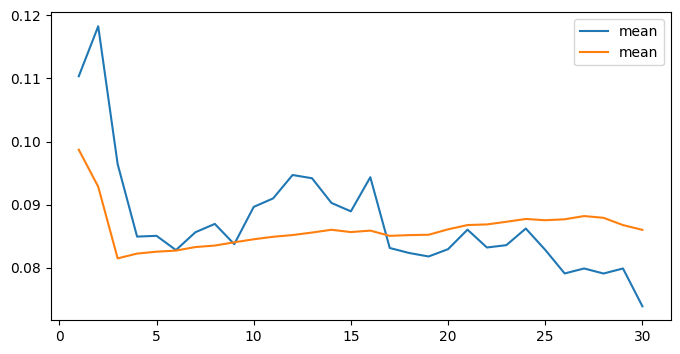

In [56]:
plt.figure(figsize=(8, 4))
plt.plot(
    range(1, 31),
    backtesting_with_refit['mean'],
    label="mean",
)

# plt.fill_between(
#     range(1, 31),
#     backtesting_with_refit['median']-backtesting_with_refit['lower_0025'],
#     backtesting_with_refit['median']+backtesting_with_refit['upper_0975'],
#     alpha=0.5,
#     label="a=0.05",
# )

plt.plot(
    range(1, 31),
    pretrained['mean'],
    label="mean",
)

# plt.fill_between(
#     range(1, 31),
#     pretrained['lower_0025'],
#     pretrained['upper_0975'],
#     alpha=0.5,
#     label="a=0.05",
# )
plt.legend();

In [57]:
plt.figure(figsize=(8, 8))
backtesting_with_refit['MAPE[0.5]'].plot(label='Backtesting with refit')
# refit_1_pass['MAPE[0.95]'].plot(label='Refit (1 backword pass)')
# refit_multiple_passes['MAPE[0.95]'].plot(label='Refit (multiple backword passes)')
pretrained['MAPE[0.5]'].plot(label='Pretrained')
plt.xticks(range(0, 30), range(1, 31))
plt.xlabel('Number of weeks')
plt.ylabel('MAPE')
plt.title('Benchmark on MAPE based on X-th percentile')
plt.legend()
plt.tight_layout()
# plt.savefig("experiment_results/after_finetuning/mape_95th_perc.png");

In [ ]:
backtesting_with_refit['MAPE[0.5]'].plot(label='Backtesting with refit')
refit_1_pass['MAPE[0.5]'].plot(label='Refit (1 backword pass)')
refit_multiple_passes['MAPE[0.5]'].plot(label='Refit (multiple backword passes)')
pretrained['MAPE[0.5]'].plot(label='Pretrained')
plt.xticks(range(0, 26), range(1, 27))
plt.xlabel('Number of weeks')
plt.ylabel('MAPE')
plt.title('Benchmark on MAPE based on 50th percentile')
plt.legend()
plt.tight_layout()
plt.savefig("experiment_results/after_finetuning/mape_50th_perc.png");

In [ ]:
model_folder = "outputs/finetune/moirai_small/1st_run/checkpoints/it_load_data_train_"
data = it_data_23_24

model, test_data = get_model_data(model_folder, 26, data)

predictor = model.create_predictor(batch_size=BSZ)
forecasts = predictor.predict(test_data.input)

input_it = iter(test_data.input)
label_it = iter(test_data.label)
forecast_it = iter(forecasts)

NUM_WINDOWS = 1

fig, axes = plt.subplots(nrows=NUM_WINDOWS, ncols=1, figsize=(8, NUM_WINDOWS * 4))
plot_next_multi(
    axes,
    input_it,
    label_it,
    forecast_it,
    context_length=1 * 168,
    intervals=(0.9, 0.95),
    dim=None,
    name="Prediction",
    show_label=True,
)
plt.tight_layout()

In [ ]:
model = load_pretrained(720)

predictor = model.create_predictor(batch_size=BSZ)
forecasts = predictor.predict(test_data.input)

input_it = iter(test_data.input)
label_it = iter(test_data.label)
forecast_it = iter(forecasts)

NUM_WINDOWS = 1

fig, axes = plt.subplots(nrows=NUM_WINDOWS, ncols=1, figsize=(8, NUM_WINDOWS * 4))
plot_next_multi(
    axes,
    input_it,
    label_it,
    forecast_it,
    context_length=1 * 168,
    intervals=(0.9, 0.95),
    dim=None,
    name="Prediction",
    show_label=True,
)
plt.tight_layout()